++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++# Определение токсичных комментариев с помощью нейронной сети

1. Для построения классификатора возьмём великолепный датасет [Russian Language Toxic Comments](https://www.kaggle.com/blackmoon/russian-language-toxic-comments).

2. Для создания векторов слов применим эмбеддинг [BPE](https://nlp.h-its.org/bpemb/), используя предобученную модель.

3. Для решения задачи бинарной классификации (toxic / nontoxic) применим фреймворк [Flair](https://github.com/zalandoresearch/flair). Flair - небольшой активно развивающийся фреймворк для некоторых задач NLP (классификация текстов, NER), работающий поверх Pytorch. С его помощью можно буквально за несколько строк собрать NLP-модель, используя самые передовые технологии обработки естественного языка.


In [1]:
import pandas as pd
import numpy as np
import re

from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import BytePairEmbeddings
from flair.embeddings import DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.visual.training_curves import Plotter

from flair.data import Sentence

import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


<Figure size 1200x600 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Установка библиотек, если они ещё не установлены
# !pip install numpy scikit-learn xgboost

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


## 1. Анализ и подготовка датасета

Скачать датасет можно по этим ссылкам:
* Ссылка на страницу датасета: [Russian Language Toxic Comments](https://www.kaggle.com/blackmoon/russian-language-toxic-comments).
* Ссылка на файл: [russian-language-toxic-comments.zip](https://www.kaggle.com/blackmoon/russian-language-toxic-comments/downloads/russian-language-toxic-comments.zip)

Скачать датасет можно так:



```
wget -O save/path/file.zip https://www.kaggle.com/blackmoon/russian-language-toxic-comments/downloads/russian-language-toxic-comments.zip
```

Потом разархивировать:


```
unzip file.zip
```



In [3]:
df = pd.read_csv('labeled.csv')

In [5]:
df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


C:\Users\Нур\AppData\Local\Temp\ipykernel_6868\1500789768.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(toxic_counts, palette='viridis')


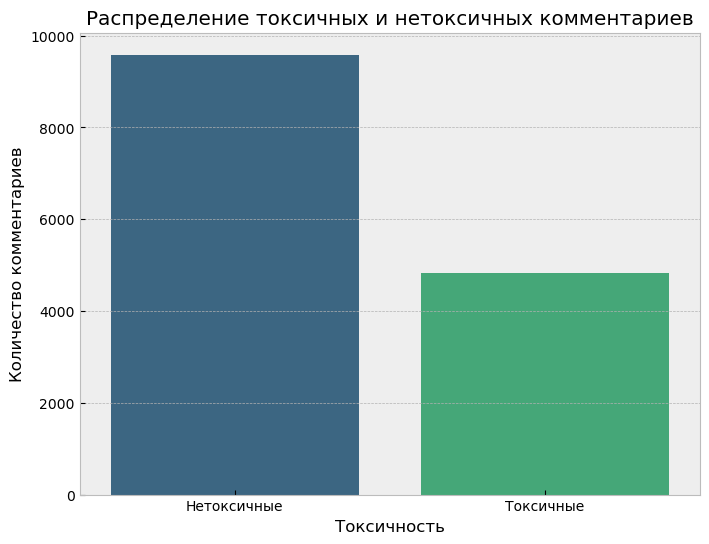

In [6]:
# 1. Распределение токсичных и нетоксичных комментариев
toxic_counts = df['toxic'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(toxic_counts, palette='viridis')
plt.title('Распределение токсичных и нетоксичных комментариев')
plt.xlabel('Токсичность')
plt.ylabel('Количество комментариев')
plt.xticks(range(len(toxic_counts.index)), ['Нетоксичные', 'Токсичные'])
plt.show()

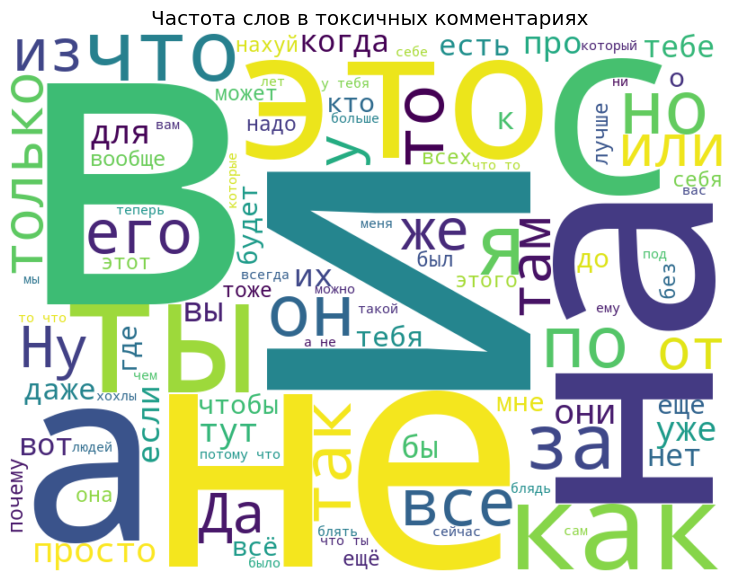

In [7]:
# 3. Частота слов в токсичных комментариях
# Собираем все токсичные комментарии в один текстовый блок
toxic_comments_text = ' '.join(df[df['toxic'] == 1]['comment'].values)

# Создаем облако слов
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=600, max_words=100).generate(toxic_comments_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Частота слов в токсичных комментариях')
plt.show()

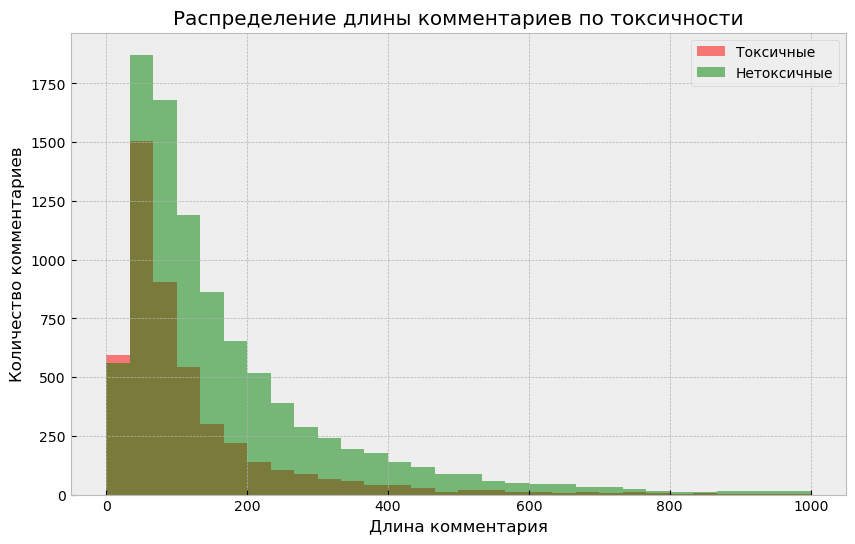

In [8]:
df['comment_length'] = df['comment'].apply(len)
# Попробуем другой подход к визуализации, используя базовые возможности matplotlib
plt.figure(figsize=(10, 6))

# Разделяем комментарии на токсичные и нетоксичные для отдельной визуализации
toxic_comments = df[df['toxic'] == 1]['comment_length']
nontoxic_comments = df[df['toxic'] == 0]['comment_length']

# Гистограмма для токсичных комментариев
plt.hist(toxic_comments, bins=30, alpha=0.5, label='Токсичные', color='red', range=(0, 1000))

# Гистограмма для нетоксичных комментариев
plt.hist(nontoxic_comments, bins=30, alpha=0.5, label='Нетоксичные', color='green', range=(0, 1000))

plt.title('Распределение длины комментариев по токсичности')
plt.xlabel('Длина комментария')
plt.ylabel('Количество комментариев')
plt.legend()
plt.show()

In [9]:
# Сначала загрузите nltk ресурсы (стоп-слова и стеммер), если вы еще этого не сделали
nltk.download('stopwords')

# Определение стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

# Инициализация стеммера (можно заменить на лемматизатор, если необходимо)
stemmer = SnowballStemmer('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Нур\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def clean_text(text):
    # Удаление специальных символов и приведение к нижнему регистру
    text = re.sub(r'\W', ' ', str(text))
    text = text.lower()
    # Удаление одиночных символов
    text = re.sub(r'\s+[а-яА-Я]\s+', ' ', text)
    # Удаление символов в начале строки
    text = re.sub(r'\^[а-яА-Я]\s+', ' ', text) 
    # Замена множественных пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Удаление префикса "b"
    text = re.sub(r'^b\s+', '', text)
    # Удаление стоп-слов и стемминг
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [11]:
Удаление специальных символов и приведение к нижнему регистру
Удаление одиночных символов
Удаление символов в начале строки
Замена множественных пробелов на один
Удаление префиков
 Удаление стоп-слов и стемминг

SyntaxError: invalid syntax (3176195575.py, line 1)

In [12]:
# Применение функции очистки к каждому комментарию
df['cleaned_comment'] = df['comment'].apply(clean_text)

# Проверка результатов
df[['comment', 'cleaned_comment']].head()

,comment,cleaned_comment
0,"Верблюдов-то за что? Дебилы, бл...\n",верблюд дебил бл
1,"Хохлы, это отдушина затюканого россиянина, мол...",хохл эт отдушин затюкан россиянин мол вон хохл...
2,Собаке - собачья смерть\n,собак собач смерт
3,"Страницу обнови, дебил. Это тоже не оскорблени...",страниц обнов деб эт оскорблен доказа факт деб...
4,"тебя не убедил 6-страничный пдф в том, что Скр...",убед 6 страничн пдф скрипал отрав росс анализи...


In [13]:
data=df[['cleaned_comment','toxic']]

In [14]:
data

,cleaned_comment,toxic
0,верблюд дебил бл,1.0
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1.0
2,собак собач смерт,1.0
3,страниц обнов деб эт оскорблен доказа факт деб...,1.0
4,убед 6 страничн пдф скрипал отрав росс анализи...,1.0
...,...,...
14407,вонюч совков скот прибежа ноет сторонник демок...,1.0
14408,ког люб гоблин тупорыл как продажн сук демшиз ...,1.0
14409,посмотрел утомлен солнц 2 оказа эт хорош фильм...,0.0
14410,крымотред наруша прав раздел нем обсужден поли...,1.0


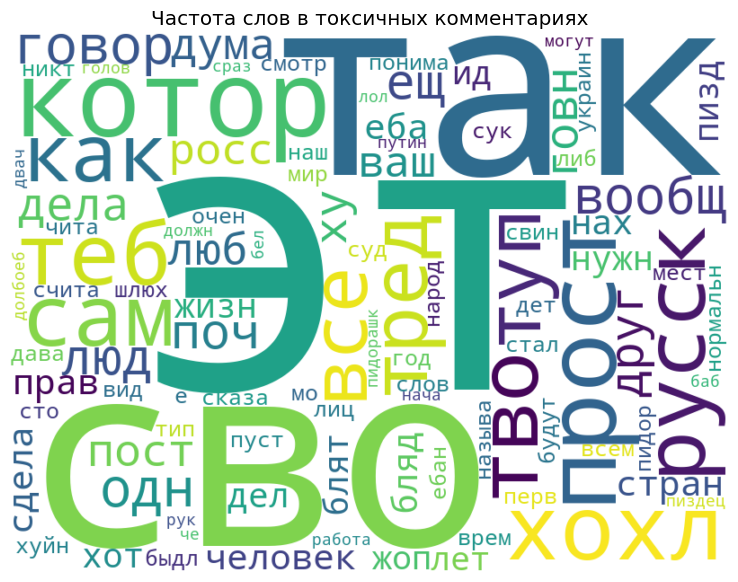

In [15]:
# 3. Частота слов в токсичных комментариях
# Собираем все токсичные комментарии в один текстовый блок
toxic_comments_text = ' '.join(data[data['toxic'] == 1]['cleaned_comment'].values)

# Создаем облако слов
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=600, max_words=100).generate(toxic_comments_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Частота слов в токсичных комментариях')
plt.show()

In [16]:
data['tokenized_comments'] = data['cleaned_comment'].apply(lambda x: x.split())

C:\Users\Нур\AppData\Local\Temp\ipykernel_6868\2648673843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tokenized_comments'] = data['cleaned_comment'].apply(lambda x: x.split())


In [17]:
from gensim.models import Word2Vec

# Обучение модели Word2Vec
model = Word2Vec(sentences=data['tokenized_comments'], vector_size=100, window=5, min_count=1, workers=4)

# Сохранение обученной модели
model.save("word2vec.model")


In [18]:
# Функция для получения среднего вектора комментария
def comment_to_avg_vector(comment, model):
    words = comment.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

In [19]:
# Преобразование всех комментариев в средние векторы
data['comment_vector'] = data['cleaned_comment'].apply(lambda x: comment_to_avg_vector(x, model))

# Пример использования векторов для обучения классификатора
# Здесь `comment_vector` является признаком, а `toxic` – целевой переменной

In [20]:
data

,cleaned_comment,toxic,tokenized_comments,comment_vector
0,верблюд дебил бл,1.0,"[верблюд, дебил, бл]","[-0.11367669, 0.11944824, 0.014339405, 0.00786..."
1,хохл эт отдушин затюкан россиянин мол вон хохл...,1.0,"[хохл, эт, отдушин, затюкан, россиянин, мол, в...","[-0.43189856, 0.42789736, 0.07089827, 0.030274..."
2,собак собач смерт,1.0,"[собак, собач, смерт]","[-0.34607735, 0.35160828, 0.04766512, 0.017975..."
3,страниц обнов деб эт оскорблен доказа факт деб...,1.0,"[страниц, обнов, деб, эт, оскорблен, доказа, ф...","[-0.47064385, 0.4678663, 0.07553557, 0.0338299..."
4,убед 6 страничн пдф скрипал отрав росс анализи...,1.0,"[убед, 6, страничн, пдф, скрипал, отрав, росс,...","[-0.32612658, 0.3479764, 0.041286137, 0.022512..."
...,...,...,...,...
14407,вонюч совков скот прибежа ноет сторонник демок...,1.0,"[вонюч, совков, скот, прибежа, ноет, сторонник...","[-0.208366, 0.20867088, 0.029417047, 0.0172391..."
14408,ког люб гоблин тупорыл как продажн сук демшиз ...,1.0,"[ког, люб, гоблин, тупорыл, как, продажн, сук,...","[-0.4759867, 0.4722876, 0.08051043, 0.04209280..."
14409,посмотрел утомлен солнц 2 оказа эт хорош фильм...,0.0,"[посмотрел, утомлен, солнц, 2, оказа, эт, хоро...","[-0.47166303, 0.483623, 0.07006009, 0.03441749..."
14410,крымотред наруша прав раздел нем обсужден поли...,1.0,"[крымотред, наруша, прав, раздел, нем, обсужде...","[-0.42263147, 0.41628736, 0.06831725, 0.032075..."


In [22]:
data[['cleaned_comment','comment_vector']]

,cleaned_comment,comment_vector
0,верблюд дебил бл,"[-0.11367669, 0.11944824, 0.014339405, 0.00786..."
1,хохл эт отдушин затюкан россиянин мол вон хохл...,"[-0.43189856, 0.42789736, 0.07089827, 0.030274..."
2,собак собач смерт,"[-0.34607735, 0.35160828, 0.04766512, 0.017975..."
3,страниц обнов деб эт оскорблен доказа факт деб...,"[-0.47064385, 0.4678663, 0.07553557, 0.0338299..."
4,убед 6 страничн пдф скрипал отрав росс анализи...,"[-0.32612658, 0.3479764, 0.041286137, 0.022512..."
...,...,...
14407,вонюч совков скот прибежа ноет сторонник демок...,"[-0.208366, 0.20867088, 0.029417047, 0.0172391..."
14408,ког люб гоблин тупорыл как продажн сук демшиз ...,"[-0.4759867, 0.4722876, 0.08051043, 0.04209280..."
14409,посмотрел утомлен солнц 2 оказа эт хорош фильм...,"[-0.47166303, 0.483623, 0.07006009, 0.03441749..."
14410,крымотред наруша прав раздел нем обсужден поли...,"[-0.42263147, 0.41628736, 0.06831725, 0.032075..."


Разбиваем предобработанный датасет на три выборки:
* обучающую
* валидационную
* тестовую

In [25]:
# https://stackoverflow.com/a/38251063
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [26]:
#del data['original_length'],data['cleaned_length']

In [30]:
del data['tokenized_comments']
del data['cleaned_comment']

In [32]:
data.head()

,toxic,comment_vector
0,1.0,"[-0.10874034, 0.11766139, 0.05873613, 0.020079..."
1,1.0,"[-0.4245231, 0.4310064, 0.23944946, 0.07670208..."
2,1.0,"[-0.336332, 0.35232005, 0.1875618, 0.058874402..."
3,1.0,"[-0.4645303, 0.46867493, 0.26126266, 0.0845778..."
4,1.0,"[-0.32449043, 0.36152023, 0.18604602, 0.063201..."


In [33]:
train, validate, test = train_validate_test_split(data, train_percent=.7, validate_percent=.2, seed=700)
train.shape[0], validate.shape[0], test.shape[0]

(10088, 2882, 1442)

In [62]:
data

,toxic,comment_vector
0,1.0,"[-0.10874034, 0.11766139, 0.05873613, 0.020079..."
1,1.0,"[-0.4245231, 0.4310064, 0.23944946, 0.07670208..."
2,1.0,"[-0.336332, 0.35232005, 0.1875618, 0.058874402..."
3,1.0,"[-0.4645303, 0.46867493, 0.26126266, 0.0845778..."
4,1.0,"[-0.32449043, 0.36152023, 0.18604602, 0.063201..."
...,...,...
14407,1.0,"[-0.20350635, 0.21088812, 0.11417003, 0.040617..."
14408,1.0,"[-0.46702936, 0.4758747, 0.2670164, 0.09289049..."
14409,0.0,"[-0.46924442, 0.49368912, 0.26608557, 0.088562..."
14410,1.0,"[-0.4187985, 0.41858914, 0.23570286, 0.0800112..."


In [56]:
train.shape, validate.shape, test.shape

((10088, 2), (2882, 2), (1442, 2))

In [34]:
X_train = np.array(train['comment_vector'].tolist())
y_train = train['toxic'].values

X_validate = np.array(validate['comment_vector'].tolist())
y_validate = validate['toxic'].values

X_test = np.array(test['comment_vector'].tolist())
y_test = test['toxic'].values

In [38]:
X_train[0]

array([-0.46770123,  0.46692997,  0.26195747,  0.09106524,  0.10227349,
       -0.88224858,  0.12214285,  0.98275703, -0.21618851, -0.24853285,
       -0.30777135, -0.7035464 , -0.4742696 ,  0.35576552,  0.14657657,
       -0.38369596,  0.00147505, -0.64731473, -0.08905145, -0.77177137,
        0.3898173 ,  0.27960619,  0.34748277, -0.2337503 ,  0.14101225,
       -0.05713672, -0.33960742, -0.10723591, -0.71333647, -0.11471508,
        0.35099635,  0.03090385, -0.01768505, -0.21188061, -0.06704842,
        0.49326757,  0.12173057, -0.38772351, -0.16412573, -0.92348355,
       -0.10603955, -0.5566569 , -0.28340134, -0.01620795,  0.58018851,
       -0.35796633, -0.46569085,  0.12059312,  0.20393129,  0.42772192,
        0.17616436, -0.25490737, -0.05095528, -0.10051244, -0.24554564,
       -0.08667785,  0.43222001, -0.2182986 , -0.61296415,  0.28212038,
        0.18723598,  0.24235527, -0.09641849, -0.15373473, -0.47711214,
        0.27377996,  0.25412947,  0.73739541, -0.44111243,  0.47

# Логистическая регрессия


In [39]:
from sklearn.linear_model import LogisticRegression

# Параметры для GridSearchCV
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], # Регуляризация
    'solver': ['liblinear', 'saga'] # Алгоритм оптимизации
}

# Создание GridSearchCV
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для логистической регрессии:", grid_lr.best_params_)
print(classification_report(y_validate, grid_lr.predict(X_validate)))

D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\Tool\anaconda\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Лучшие параметры для логистической регрессии: {'C': 100, 'solver': 'liblinear'}
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83      1938
         1.0       0.68      0.44      0.53       944

    accuracy                           0.75      2882
   macro avg       0.72      0.67      0.68      2882
weighted avg       0.74      0.75      0.73      2882



In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.datasets import make_classification

In [44]:
best_model_lr = grid_lr.best_estimator_
y_pred = best_model_lr.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.7392
SVC Recall: 0.7434
SVC F1 Score: 0.7239
SVC Accuracy: 0.7434


# RandomForestClassifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Параметры для GridSearchCV
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200], # Количество деревьев
    'max_depth': [None, 10, 20, 30] # Максимальная глубина деревьев
}

# Создание GridSearchCV
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для случайного леса:", grid_rf.best_params_)
print(classification_report(y_validate, grid_rf.predict(X_validate)))


Лучшие параметры для случайного леса: {'max_depth': None, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.76      0.88      0.82      1938
         1.0       0.63      0.44      0.52       944

    accuracy                           0.73      2882
   macro avg       0.70      0.66      0.67      2882
weighted avg       0.72      0.73      0.72      2882



In [45]:
best_model_rf = grid_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.7151
SVC Recall: 0.7247
SVC F1 Score: 0.7063
SVC Accuracy: 0.7247


# xgboost

In [41]:
import xgboost as xgb

# Параметры для GridSearchCV
param_grid_xgb = {
    'n_estimators': [100, 200, 300], # Количество деревьев
    'learning_rate': [0.01, 0.1, 0.2], # Скорость обучения
    'max_depth': [3, 6, 9] # Максимальная глубина деревьев
}

# Создание GridSearchCV
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

# Лучшие параметры и результаты
print("Лучшие параметры для XGBoost:", grid_xgb.best_params_)
print(classification_report(y_validate, grid_xgb.predict(X_validate)))


C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is dep

Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1938
         1.0       0.62      0.46      0.53       944

    accuracy                           0.73      2882
   macro avg       0.69      0.66      0.67      2882
weighted avg       0.72      0.73      0.72      2882



In [46]:
best_model_xgb = grid_xgb.best_estimator_
y_pred = best_model_xgb.predict(X_test)

# Calculating metrics
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.7311
SVC Recall: 0.7386
SVC F1 Score: 0.7224
SVC Accuracy: 0.7386


In [ ]:
metric_lr = {"Precision": 0.7392, "Recall": 0.7434, "F1 Score": 0.7239, "Accuracy": 0.7434}
metric_rf = {"Precision": 0.7151, "Recall": 0.7247, "F1 Score": 0.7063, "Accuracy": 0.7247}
metric_xgb = {"Precision":  0.7311, "Recall": 0.7386, "F1 Score": 0.7224, "Accuracy": 0.7386}

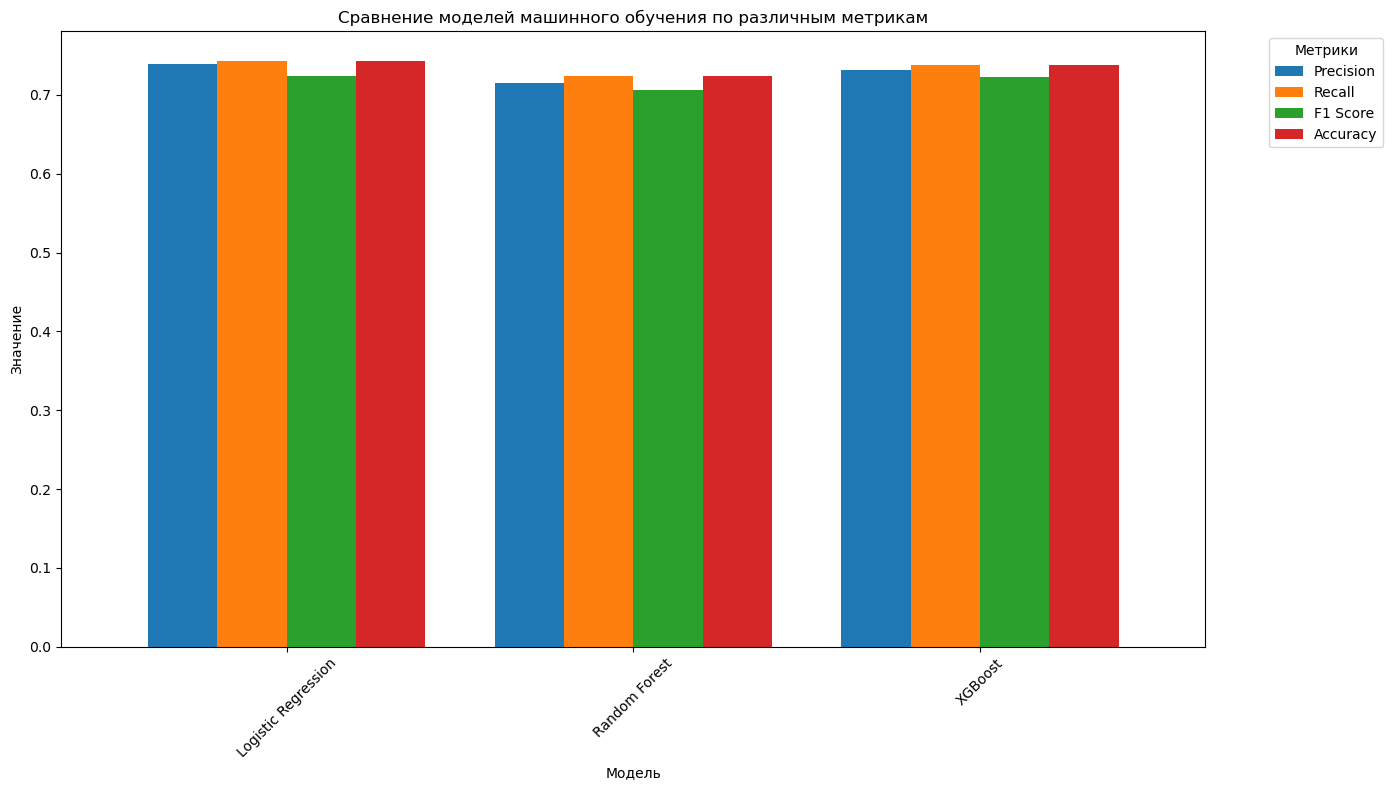

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Словари с метриками
metric_lr = {"Precision": 0.7392, "Recall": 0.7434, "F1 Score": 0.7239, "Accuracy": 0.7434}
metric_rf = {"Precision": 0.7151, "Recall": 0.7247, "F1 Score": 0.7063, "Accuracy": 0.7247}
metric_xgb = {"Precision":  0.7311, "Recall": 0.7386, "F1 Score": 0.7224, "Accuracy": 0.7386}

# Создание DataFrame
df_metrics = pd.DataFrame([metric_lr, metric_rf, metric_xgb], index=['Logistic Regression', 'Random Forest', 'XGBoost'])

# Визуализация
df_metrics.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Сравнение моделей машинного обучения по различным метрикам')
plt.ylabel('Значение')
plt.xlabel('Модель')
plt.xticks(rotation=45)
plt.legend(title='Метрики', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Показываем график
plt.show()


In [80]:
#https://chat.openai.com/g/g-pR3pPQfFY-data-science/c/e3f58b99-4111-4276-955c-e8f7849869c8

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Определение сетки гиперпараметров
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
        'penalty': ['l1', 'l2']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBClassifier': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.5],
        'max_depth': [3, 6, 9],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Результаты
results = []

# Поиск гиперпараметров и оценка моделей
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Вычисление метрик
    metrics = {
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Accuracy': accuracy_score(y_test, y_pred)
    }
    
    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Metrics': metrics
    })

# Вывод результатов
for result in results:
    print(f"Model: {result['Model']}\nBest Params: {result['Best Params']}\nMetrics: {result['Metrics']}\n")


C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Нур\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model: LogisticRegression
Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Metrics: {'Precision': 0.7313719259163088, 'Recall': 0.7385575589459085, 'F1 Score': 0.7219064380534369, 'Accuracy': 0.7385575589459085}

Model: RandomForestClassifier
Best Params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Metrics: {'Precision': 0.7176037008204645, 'Recall': 0.7260748959778086, 'F1 Score': 0.7054235384413727, 'Accuracy': 0.7260748959778086}

Model: XGBClassifier
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Metrics: {'Precision': 0.7183956324627828, 'Recall': 0.7267683772538142, 'F1 Score': 0.7063205720289826, 'Accuracy': 0.7267683772538142}



In [50]:
from joblib import dump

# Убедитесь, что папка models существует в вашей рабочей директории или укажите полный путь

# Сохранение моделей в папку models
dump(best_model_lr, 'models/best_model_lr.joblib')
dump(best_model_rf, 'models/best_model_rf.joblib')
dump(best_model_xgb, 'models/best_model_xgb.joblib')

['models/best_model_xgb.joblib']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Преобразование результатов в DataFrame для удобства визуализации
df_results = pd.DataFrame({
    'Model': [r['Model'] for r in results],
    'Precision': [r['Metrics']['Precision'] for r in results],
    'Recall': [r['Metrics']['Recall'] for r in results],
    'F1 Score': [r['Metrics']['F1 Score'] for r in results],
    'Accuracy': [r['Metrics']['Accuracy'] for r in results],
})

# Транспонирование DataFrame для визуализации
df_results_t = df_results.drop('Model', axis=1).T
df_results_t.columns = df_results['Model']


In [54]:
df_results

,Model,Precision,Recall,F1 Score,Accuracy
0,LogisticRegression,0.731372,0.738558,0.721906,0.738558
1,RandomForestClassifier,0.717604,0.726075,0.705424,0.726075
2,XGBClassifier,0.718396,0.726768,0.706321,0.726768


In [52]:
df_results_t

Model,LogisticRegression,RandomForestClassifier,XGBClassifier
Precision,0.731372,0.717604,0.718396
Recall,0.738558,0.726075,0.726768
F1 Score,0.721906,0.705424,0.706321
Accuracy,0.738558,0.726075,0.726768


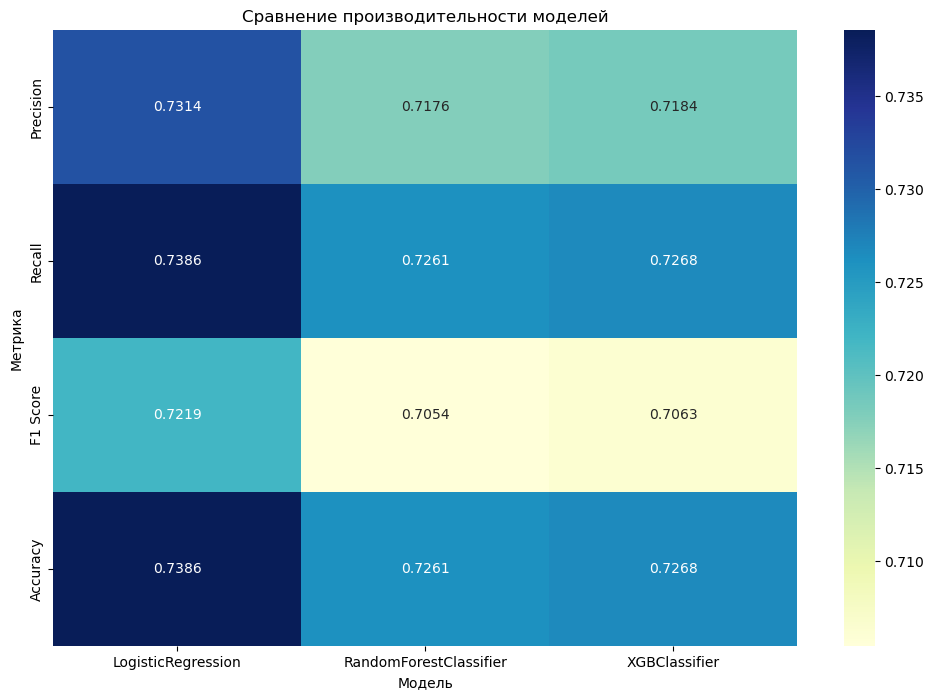

In [49]:
# Визуализация результатов
plt.figure(figsize=(12, 8))
sns.heatmap(df_results_t, annot=True, cmap="YlGnBu", fmt=".4f")
plt.title('Сравнение производительности моделей')
plt.xlabel('Модель')
plt.ylabel('Метрика')
plt.show()

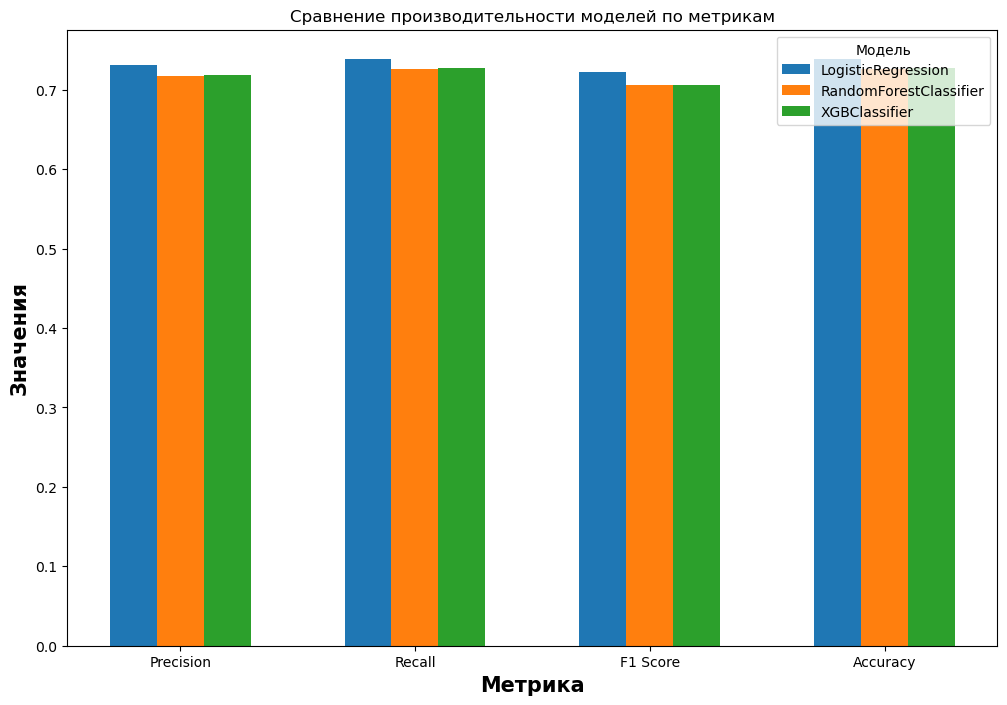

In [55]:
fig, ax = plt.subplots(figsize=(12, 8))

# Настройка положений столбцов
barWidth = 0.2
positions = np.arange(len(metrics))

for i, model in enumerate(models):
    ax.bar(positions + i * barWidth, df_results_t[model], width=barWidth, label=model)

# Добавление подписей к графику
ax.set_xlabel('Метрика', fontweight='bold', fontsize=15)
ax.set_ylabel('Значения', fontweight='bold', fontsize=15)
ax.set_xticks(positions + barWidth)
ax.set_xticklabels(metrics)
ax.legend(title='Модель')

# Заголовок графика
plt.title('Сравнение производительности моделей по метрикам')

# Отображение графика
plt.show()

# Load Models

In [51]:
from joblib import load

# Загрузка моделей из папки models
loaded_model_lr = load('models/best_model_lr.joblib')
loaded_model_rf = load('models/best_model_rf.joblib')
loaded_model_xgb = load('models/best_model_xgb.joblib')

In [83]:
df.iloc[:50,:2]

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


In [100]:
df.iloc[35,:1]

comment    Возьмём как пример Россию, западноевропейские ...
Name: 35, dtype: object

In [101]:
df.iloc[3,0]

'Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?\n'

In [81]:
from gensim.models import Word2Vec

def predict_toxicity_with_word2vec(new_comment):
    # Загрузка обученной модели Word2Vec
    word2vec_model = Word2Vec.load("word2vec.model")
    
    # Загрузка вашей классификационной модели (предположим, что это XGBoost)
    classification_model = load('models/best_model_xgb.joblib')
    
    # Предобработка комментария
    # Например, токенизация
    def preprocess_text(text):
        # Простая токенизация, разделение на слова, можно добавить другие шаги предобработки
        words = text.lower().split()
        return words
    
    # Преобразование комментария в средний вектор
    def comment_to_mean_vector(comment):
        words = preprocess_text(comment)
        word_vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        
        if len(word_vectors) == 0:
            return np.zeros(word2vec_model.vector_size)
        else:
            return np.mean(word_vectors, axis=0)
    
    # Получение вектора для нового комментария
    comment_vector = comment_to_mean_vector(new_comment).reshape(1, -1)  # Reshape для соответствия ожидаемому входу модели
    
    # Предсказание с использованием модели
    prediction = classification_model.predict(comment_vector)
    
    return prediction[0]

In [93]:
# Пример использования функции
new_comment = "я тебя убью"
prediction = predict_toxicity_with_word2vec(new_comment)
print(f"Предсказание модели: {prediction}")

Предсказание модели: 1


In [94]:
# Пример использования функции
new_comment = "Про то писать кириллицей или латинницей вам виднее, не спорю. Но как задвигают русский язык уже видно. Дальше скажут что все будет только на казахском и внезапно пол страны окажется вторым сортом. (Я надеюсь, что ошибаюсь, но это уже проходили в других странах азии, прибалтики, закавказья) А так я за мир во всем мире. Русский слон лучший друг Казахского слона.\n"
prediction = predict_toxicity_with_word2vec(new_comment)
print(f"Предсказание модели: {prediction}")

Предсказание модели: 0


In [99]:
# Пример использования функции
new_comment = "Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?"
prediction = predict_toxicity_with_word2vec(new_comment)
print(f"Предсказание модели: {prediction}")

Предсказание модели: 0


In [ ]:
predict_toxicity_with_word2vec(new_comment)

In [128]:
# Функция для получения среднего вектора комментария
def comment_to_avg_vector(comment):
    model = Word2Vec.load("word2vec.model")
    words = comment.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

In [ ]:
# Преобразование всех комментариев в средние векторы
data['comment_vector'] = data['cleaned_comment'].apply(lambda x: comment_to_avg_vector(x))

In [142]:
hh = pd.DataFrame(df.sample(n=100))
hh_y=goh.toxic
hh_x=goh.comment


hh_x= hh_x.apply(lambda x: comment_to_avg_vector(x))
hh_x = np.array(hh_x.tolist())

In [143]:
(hh_x)

array([[-3.77564393e-02,  4.89777811e-02,  3.08182575e-02, ...,
        -4.77066599e-02,  1.22235576e-02,  9.88716783e-05],
       [-6.22350752e-01,  7.61610448e-01,  3.46205175e-01, ...,
        -9.93715644e-01,  3.12851638e-01, -1.00770652e-01],
       [-2.27373540e-01,  2.36086309e-01,  1.31674945e-01, ...,
        -2.93042421e-01,  7.77301490e-02, -9.25420783e-03],
       ...,
       [-7.14756772e-02,  8.20458308e-02,  3.74069996e-02, ...,
        -9.04364362e-02,  2.40364131e-02,  9.71800240e-04],
       [-2.65115261e-01,  2.76410371e-01,  1.56374902e-01, ...,
        -3.37573200e-01,  8.48079696e-02, -3.99421155e-03],
       [-2.08605886e-01,  2.21860006e-01,  1.13059789e-01, ...,
        -2.66175121e-01,  6.90471828e-02, -9.47645586e-03]])

In [136]:
X_test

array([[-0.4248135 ,  0.4354201 ,  0.23986438, ..., -0.5185162 ,
         0.13031222, -0.00334364],
       [-0.7190597 ,  0.7269269 ,  0.40766048, ..., -0.8314941 ,
         0.1987856 ,  0.01393686],
       [-0.5133545 ,  0.5249049 ,  0.29094502, ..., -0.6336567 ,
         0.16045894, -0.01019695],
       ...,
       [-0.3107012 ,  0.31199268,  0.18067166, ..., -0.36939627,
         0.09486002,  0.00499838],
       [-0.40539387,  0.42298672,  0.22970104, ..., -0.50645566,
         0.13018435, -0.00824453],
       [-0.354708  ,  0.39024606,  0.19925146, ..., -0.4844772 ,
         0.13434343, -0.02525468]], dtype=float32)

In [145]:
hh_pred=best_model_rf.predict(hh_x)

# Calculating metrics
precision = precision_score(hh_y, hh_pred, average='weighted')
recall = recall_score(hh_y, hh_pred, average='weighted')
f1 = f1_score(hh_y, hh_pred, average='weighted')
accuracy = accuracy_score(hh_y, hh_pred)

print(f"SVC Precision: {precision:.4f}")
print(f"SVC Recall: {recall:.4f}")
print(f"SVC F1 Score: {f1:.4f}")
print(f"SVC Accuracy: {accuracy:.4f}")

SVC Precision: 0.5442
SVC Recall: 0.5400
SVC F1 Score: 0.5419
SVC Accuracy: 0.5400


In [132]:
from gensim.models import Word2Vec

def predict_toxicity_with_word2vec(new_comment):
    classification_model = load('models/best_model_xgb.joblib')
  
    # Предсказание с использованием модели
    prediction = classification_model.predict(new_comment)
    
    return prediction